# AUTOENCODERS

* An unsupervised learning technique.
* Takes an image input and try to reconstruct it using fewer number of bits from the bottle neck, also known as latent space.
* Autoencoders are similar to dimensionallity reduction techniques like PCA.
* PCA uses linear transformation whereas autoencoders use non-linear transformation.

For example feed an image with just five pixel values to the autoencoder which is compresses by the encoder into 3 pixels at the bottle neck(middle layer). Using these three values the decoder tries to resconstruct the five pixel values.

**Types of Autoencoders:**
* Convolutional Autoencoder
* Denoising Autoencoder
* Variational Autoencoder
* Sparse Autoencoder

# Applying Autoencoder on MNIST Data

## Imports

In [1]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
pd.set_option('max_colwidth', 999)
pd.set_option('display.max_columns', 999)
pd.set_option("display.max_rows", 999)
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input, Dense, Flatten, Dropout, merge, Reshape, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adadelta, RMSprop, SGD, Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
%matplotlib inline

Using TensorFlow backend.
/root/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/root/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/root/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/root/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtype

## Utility Functions

Here define functions that opens the gzip files and reads them using **bytestream.read()** pass the image dimension and the number of images you have in total to this function. Then, using **np.frombuffer()**, convert the string stored in variable buf into a NumPy array of type float32.

Once it is converted into a NumPy array, reshape the array into a three-dimensional array or tensor where the first dimension is a number of images, and the second and third dimension being the dimension of the image. Finally, return the NumPy array data.

In [2]:
def extract_data(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(28 * 28 * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, 28, 28)
        return data

In [3]:
# Calling the extract_data function by passing the training and testing files along with the corresponding number of images.

train_data = extract_data('train-images-idx3-ubyte.gz', 60000)
test_data = extract_data('t10k-images-idx3-ubyte.gz', 10000)

Define similar function for reading labels.

In [4]:
def extract_labels(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
        return labels

In [5]:
# Calling the above function to read labels.

train_labels = extract_labels('train-labels-idx1-ubyte.gz', 60000)
test_labels = extract_labels('t10k-labels-idx1-ubyte.gz', 10000)

## Data Exploration

In [6]:
# Shapes of training set
print("Training set (images) shape: {shape}".format(shape=train_data.shape))

# Shapes of test set
print("Test set (images) shape: {shape}".format(shape=test_data.shape))

Training set (images) shape: (60000, 28, 28)
Test set (images) shape: (10000, 28, 28)


In [7]:
# Creating a dictionary that will contain class labels coressponding to class name.

label_dict = {
    0: 'A',
    1: 'B',
    2: 'C',
    3: 'D',
    4: 'E',
    5: 'F',
    6: 'G',
    7: 'H',
    8: 'I',
    9: 'J',
}

**Looking at couple images in the data**

Text(0.5, 1.0, '(Label: E)')

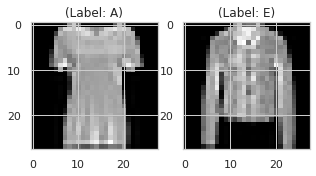

In [8]:
plt.figure(figsize=[5, 5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(train_data[10], (28, 28))
curr_lbl = train_labels[10]
plt.imshow(curr_img,cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(test_data[10], (28, 28))
curr_lbl = test_labels[10]
plt.imshow(curr_img,cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

## Data Preprocessing

Each image in the train and test are gray scale images pixels ranging from 0-255. Each image is of the size of 28x28, so we need to convert it into the size of 28x28x1 so that they can be feeded to the model.

In [9]:
train_data = train_data.reshape(-1, 28, 28, 1)
test_data = test_data.reshape(-1, 28, 28, 1)
train_data.shape, test_data.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

Need to check the datatype of numpy array for each image data, it should be float32. Also need to rescale the pixels in the range of 0-1 inclusive.

In [10]:
train_data.dtype, test_data.dtype

(dtype('float32'), dtype('float32'))

In [11]:
# Rescaling the data.
np.max(train_data), np.max(test_data)

(255.0, 255.0)

In [12]:
train_data = train_data / np.max(train_data)
test_data = test_data / np.max(test_data)

In [13]:
# Checking the maximum value after rescatling the data.
np.max(train_data), np.max(test_data)

(1.0, 1.0)

Split the training data into two parts: Training and Validation, model will train on 80% of the data and remaining 20% will be used for validation of the model, this will reduce chances of overfitting.

In [14]:
from sklearn.model_selection import train_test_split
train_X, valid_X, train_ground, valid_ground = train_test_split(
    train_data, train_data, test_size=0.2, random_state=13)

In the above cell **train_data** is passed twice because autoencoder doesn't need labels to learn, it will learn by looking at the training data only.

For classification task above code will be needed to be run again, the only change would be about labels, during classification we would require labels too.


## The Convolutional Encoder

Autoencoder has two parts **Encoder** **Decoder**

* **Encoder :-**  It has 4 Convolution blocks, each block has a convolution layer followed by a batch normalization layer. Max-pooling layer is used after the first and second convolution blocks.
    * The first convolution block will have 32 filters of size 3 x 3, followed by a downsampling (max-pooling) layer,
    * The second block will have 64 filters of size 3 x 3, followed by another downsampling layer,
    * The third block of encoder will have 128 filters of size 3 x 3,
    * The fourth block of encoder will have 256 filters of size 3 x 3.
    
* **Decoder :-**  It has 3 Convolution blocks, each block has a convolution layer followed by a batch normalization layer. Upsampling layer is used after the second and third convolution blocks.
    * The first block will have 128 filters of size 3 x 3,
    * The second block will have 64 filters of size 3 x 3 followed by another upsampling layer,
    * The third block will have 32 filters of size 3 x 3 followed by another upsampling layer,
    * The final layer of encoder will have 1 filter of size 3 x 3 which will reconstruct back the input having a single channel.
    
The max-pooling layer will downsample the input by two times each time it is used, while the upsampling layer will upsample the input by two times each time it is used.

**Note:** The number of filters, the filter size, the number of layers, number of epochs you train your model, are all hyperparameters and should be decided based on your own intuition, you are free to try new experiments by tweaking with these hyperparameters and measure the performance of your model. And that is how you will slowly learn the art of deep learning!

### Creating Encoder and Decoder

In [15]:
batch_size = 64
epochs = 200
inChannel = 1
x, y = 28, 28
input_img = Input(shape=(x, y, inChannel))
num_classes = 10

In [16]:
# Creating Encoder and Decoder Functions.


def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu',
                   padding='same')(input_img)  #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)  #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu',
                   padding='same')(pool1)  #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)  #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu',
                   padding='same')(pool2)  #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu',
                   padding='same')(conv3)  #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4


def decoder(conv4):
    #decoder
    conv5 = Conv2D(128, (3, 3), activation='relu',
                   padding='same')(conv4)  #7 x 7 x 128
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu',
                   padding='same')(conv5)  #7 x 7 x 64
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2, 2))(conv6)  #14 x 14 x 64
    conv7 = Conv2D(32, (3, 3), activation='relu',
                   padding='same')(up1)  # 14 x 14 x 32
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2, 2))(conv7)  # 28 x 28 x 32
    decoded = Conv2D(1, (3, 3), activation='sigmoid',
                     padding='same')(up2)  # 28 x 28 x 1
    return decoded

### Compiling The Model

In [17]:
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='mean_squared_error', optimizer=RMSprop())

In [18]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        1849

### Training The Model

In [19]:
# Train using keras fit function.

autoencoder_train = autoencoder.fit(train_X,
                                    train_ground,
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    verbose=1,
                                    validation_data=(valid_X, valid_ground))


Train on 48000 samples, validate on 12000 samples
Epoch 1/200
48000/48000 [==============================] - 135s 3ms/step - loss: 0.0201 - val_loss: 0.0142
Epoch 2/200
48000/48000 [==============================] - 127s 3ms/step - loss: 0.0087 - val_loss: 0.0078
Epoch 3/200
48000/48000 [==============================] - 126s 3ms/step - loss: 0.0068 - val_loss: 0.0078
Epoch 4/200
48000/48000 [==============================] - 125s 3ms/step - loss: 0.0057 - val_loss: 0.0057
Epoch 5/200
48000/48000 [==============================] - 125s 3ms/step - loss: 0.0051 - val_loss: 0.0053
Epoch 6/200
48000/48000 [==============================] - 128s 3ms/step - loss: 0.0045 - val_loss: 0.0057
Epoch 7/200
48000/48000 [==============================] - 125s 3ms/step - loss: 0.0040 - val_loss: 0.0042
Epoch 8/200
48000/48000 [==============================] - 126s 3ms/step - loss: 0.0037 - val_loss: 0.0046
Epoch 9/200
48000/48000 [==============================] - 125s 3ms/step - loss: 0.0034 - val

48000/48000 [==============================] - 125s 3ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 75/200
48000/48000 [==============================] - 126s 3ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 76/200
48000/48000 [==============================] - 127s 3ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 77/200
48000/48000 [==============================] - 125s 3ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 78/200
48000/48000 [==============================] - 125s 3ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 79/200
48000/48000 [==============================] - 126s 3ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 80/200
48000/48000 [==============================] - 126s 3ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 81/200
48000/48000 [==============================] - 127s 3ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 82/200
48000/48000 [==============================] - 126s 3ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 83/200
48000/48000 [===============

48000/48000 [==============================] - 126s 3ms/step - loss: 7.9405e-04 - val_loss: 0.0010
Epoch 148/200
48000/48000 [==============================] - 124s 3ms/step - loss: 7.9263e-04 - val_loss: 0.0010
Epoch 149/200
48000/48000 [==============================] - 125s 3ms/step - loss: 7.9089e-04 - val_loss: 0.0011
Epoch 150/200
48000/48000 [==============================] - 124s 3ms/step - loss: 7.8486e-04 - val_loss: 0.0010
Epoch 151/200
48000/48000 [==============================] - 125s 3ms/step - loss: 7.8283e-04 - val_loss: 9.7705e-04
Epoch 152/200
48000/48000 [==============================] - 125s 3ms/step - loss: 7.7783e-04 - val_loss: 0.0010
Epoch 153/200
48000/48000 [==============================] - 125s 3ms/step - loss: 7.7981e-04 - val_loss: 0.0010
Epoch 154/200
48000/48000 [==============================] - 126s 3ms/step - loss: 7.7919e-04 - val_loss: 0.0011
Epoch 155/200
48000/48000 [==============================] - 126s 3ms/step - loss: 7.7586e-04 - val_loss: 

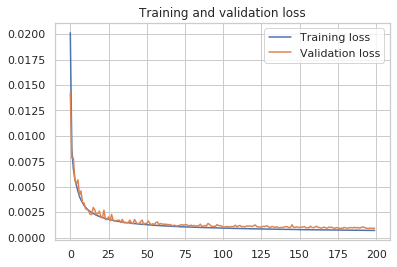

In [20]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(200)
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [21]:
autoencoder.save_weights('autoencoder.h5')

## Segmenting The Fashion MNIST Images

**Convert the labels into one-hot encoding**

In [22]:
train_Y_one_hot = to_categorical(train_labels)
test_Y_one_hot = to_categorical(test_labels)

# Display the change for category label using one-hot encoding
print('Original label:', train_labels[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 9
After conversion to one-hot: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


Split the data set into training and testing sets, but this time pass the labels too, because of classification task.

In [23]:
train_X, valid_X, train_label, valid_label = train_test_split(train_data,
                                                              train_Y_one_hot,
                                                              test_size=0.2,
                                                              random_state=13)

In [24]:
train_X.shape, valid_X.shape, train_label.shape, valid_label.shape

((48000, 28, 28, 1), (12000, 28, 28, 1), (48000, 10), (12000, 10))

# Classification Model

## Encoder Part

**Will be using the exact same encoder part as used in the Autoencoder architecture.**

In [25]:
def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

## Fully Connected Layers

**Defining fully connected layers that we will be stacking up with the encoder function.**

In [26]:
def fc(enco):
    flat = Flatten()(enco)
    den = Dense(128, activation='relu')(flat)
    out = Dense(num_classes, activation='softmax')(den)
    return out

In [27]:
encode = encoder(input_img)
full_model = Model(input_img,fc(encode))

In [28]:
for l1,l2 in zip(full_model.layers[:19],autoencoder.layers[0:19]):
    l1.set_weights(l2.get_weights())

**Note :-** The next step is pretty important. In order to be sure whether the weights of the encoder part of the autoencoder are similar to the weights you loaded to the encoder function of the classification model, you should always print any one of the same layers weights of both the models. If they are not similar, then there is no use in using the autoencoder classification strategy.

In [29]:
# Checking if the weights are equal for both models.

autoencoder.get_weights()[0][1] == full_model.get_weights()[0][1]

array([[[ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True]],

       [[ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True]],

       [[ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True]]])

Both the arrays look exactly similar.

Next we will make the encoder part i.e. the first 19 layers of the model trainable false. Since the encoder part is already trained, we do not need to train it. We will only be training the fully connected part.

In [30]:
# Setting first 19 layers trainable false.
for layer in full_model.layers[0:19]:
    layer.trainable = False

## Compiling the Model

In [31]:
# Compiling the model
full_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [32]:
# Printing model summary.
full_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_15 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_16 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 14, 14, 64)        1849

## Train the Model

Train the model with Keras' fit() function! The model trains for 10 epochs. The fit() function will return a history object; By storing the result of this function in fashion_train, we can use it later to plot the accuracy and loss function plots between training and validation which will help to analyze your model's performance visually.

In [33]:
classify_train = full_model.fit(train_X, train_label, batch_size=64,epochs=100,verbose=1,validation_data=(valid_X, valid_label))

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 40s 838us/step - loss: 0.3729 - accuracy: 0.8706 - val_loss: 0.2850 - val_accuracy: 0.8985
Epoch 2/100
48000/48000 [==============================] - 40s 836us/step - loss: 0.2308 - accuracy: 0.9165 - val_loss: 0.2948 - val_accuracy: 0.9007
Epoch 3/100
48000/48000 [==============================] - 41s 845us/step - loss: 0.1860 - accuracy: 0.9305 - val_loss: 0.2935 - val_accuracy: 0.9044
Epoch 4/100
48000/48000 [==============================] - 40s 836us/step - loss: 0.1597 - accuracy: 0.9398 - val_loss: 0.2942 - val_accuracy: 0.9065
Epoch 5/100
48000/48000 [==============================] - 40s 824us/step - loss: 0.1389 - accuracy: 0.9481 - val_loss: 0.3523 - val_accuracy: 0.8945
Epoch 6/100
48000/48000 [==============================] - 40s 831us/step - loss: 0.1200 - accuracy: 0.9549 - val_loss: 0.3528 - val_accuracy: 0.9032
Epoch 7/100
48000/48000 [=========================

Epoch 55/100
48000/48000 [==============================] - 39s 821us/step - loss: 0.0228 - accuracy: 0.9934 - val_loss: 0.9992 - val_accuracy: 0.9087
Epoch 56/100
48000/48000 [==============================] - 39s 823us/step - loss: 0.0129 - accuracy: 0.9961 - val_loss: 1.0429 - val_accuracy: 0.9066
Epoch 57/100
48000/48000 [==============================] - 39s 815us/step - loss: 0.0115 - accuracy: 0.9962 - val_loss: 1.0294 - val_accuracy: 0.9112
Epoch 58/100
48000/48000 [==============================] - 39s 819us/step - loss: 0.0183 - accuracy: 0.9949 - val_loss: 1.0479 - val_accuracy: 0.9111
Epoch 59/100
48000/48000 [==============================] - 39s 819us/step - loss: 0.0198 - accuracy: 0.9944 - val_loss: 1.0079 - val_accuracy: 0.9095
Epoch 60/100
48000/48000 [==============================] - 39s 821us/step - loss: 0.0136 - accuracy: 0.9960 - val_loss: 1.0483 - val_accuracy: 0.9098
Epoch 61/100
48000/48000 [==============================] - 40s 823us/step - loss: 0.0156 - ac

Now re-train the model by keeping the first 19 layers as trainable True.

In [34]:
for layer in full_model.layers[0:19]:
    layer.trainable = True

In [35]:
full_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [36]:
classify_train = full_model.fit(train_X, train_label, batch_size=64,epochs=100,verbose=1,validation_data=(valid_X, valid_label))

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 100s 2ms/step - loss: 0.2017 - accuracy: 0.9650 - val_loss: 1.0362 - val_accuracy: 0.8979
Epoch 2/100
48000/48000 [==============================] - 97s 2ms/step - loss: 0.1083 - accuracy: 0.9737 - val_loss: 0.9235 - val_accuracy: 0.8994
Epoch 3/100
48000/48000 [==============================] - 98s 2ms/step - loss: 0.0918 - accuracy: 0.9769 - val_loss: 0.9247 - val_accuracy: 0.9018
Epoch 4/100
48000/48000 [==============================] - 98s 2ms/step - loss: 0.0659 - accuracy: 0.9808 - val_loss: 0.8841 - val_accuracy: 0.9068
Epoch 5/100
48000/48000 [==============================] - 98s 2ms/step - loss: 0.0619 - accuracy: 0.9832 - val_loss: 0.7071 - val_accuracy: 0.8970
Epoch 6/100
48000/48000 [==============================] - 98s 2ms/step - loss: 0.0616 - accuracy: 0.9817 - val_loss: 0.7162 - val_accuracy: 0.9091
Epoch 7/100
48000/48000 [==============================] - 98

48000/48000 [==============================] - 98s 2ms/step - loss: 0.0083 - accuracy: 0.9975 - val_loss: 0.8454 - val_accuracy: 0.9224
Epoch 56/100
48000/48000 [==============================] - 97s 2ms/step - loss: 0.0151 - accuracy: 0.9955 - val_loss: 1.5486 - val_accuracy: 0.9154
Epoch 57/100
48000/48000 [==============================] - 97s 2ms/step - loss: 0.0147 - accuracy: 0.9959 - val_loss: 2.0552 - val_accuracy: 0.9197
Epoch 58/100
48000/48000 [==============================] - 97s 2ms/step - loss: 0.0074 - accuracy: 0.9976 - val_loss: 3.5288 - val_accuracy: 0.9119
Epoch 59/100
48000/48000 [==============================] - 96s 2ms/step - loss: 0.0176 - accuracy: 0.9960 - val_loss: 1.1691 - val_accuracy: 0.9139
Epoch 60/100
48000/48000 [==============================] - 98s 2ms/step - loss: 0.0120 - accuracy: 0.9969 - val_loss: 1.3712 - val_accuracy: 0.9228
Epoch 61/100
48000/48000 [==============================] - 97s 2ms/step - loss: 0.0083 - accuracy: 0.9973 - val_loss: 

## Plotting the Training And Validation Results

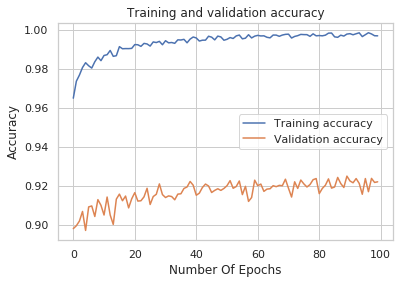

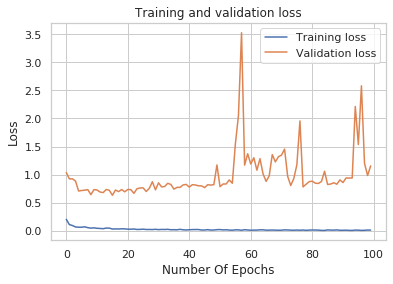

In [37]:
accuracy = classify_train.history['accuracy']
val_accuracy = classify_train.history['val_accuracy']
loss = classify_train.history['loss']
val_loss = classify_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number Of Epochs')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.xlabel('Number Of Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Since observing the above two plots we can see that model is overfitting as there is big gap between training and validation accuracy. Also, very much fluctuation between training and validation loss.

Address this overfitting by using some regularization technique like Dropout, which I'll use in upcoming sections.

## Saving The Model

In [38]:
full_model.save_weights('classification_complete.h5')

## Model Evaluation

In [39]:
test_eval = full_model.evaluate(test_data, test_Y_one_hot, verbose=0)

In [40]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.9724919557051116
Test accuracy: 0.9203000068664551


## Predict Labels

In [41]:
predicted_classes = full_model.predict(test_data)

In [42]:
predicted_classes[0]

array([0.0000000e+00, 3.2848296e-32, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 8.4969967e-16, 0.0000000e+00, 1.5935675e-18,
       1.3621221e-30, 1.0000000e+00], dtype=float32)

Since the predictions here are floating point values, it will not be feasible to compare the predicted labels with true test labels. So, we will round off the output which will convert the float value to an integer. Further, we will use **np.argmax()** to select the index number which has highest value in the row.

For example, let's assume a prediction for one test image to be [0 1 0 0 0 0 0 0 0 0], the output for this should be a class label 1.

In [43]:
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)

In [44]:
predicted_classes.shape, test_labels.shape

((10000,), (10000,))

Found 9203 correct labels


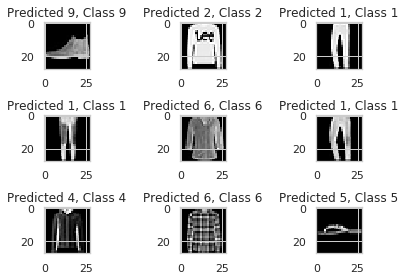

In [45]:
# Get the number of correct predictions and some plot showing the correctly predicted images.
correct = np.where(predicted_classes==test_labels)[0]
print("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_data[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], test_labels[correct]))
    plt.tight_layout()

Found 797 incorrect labels


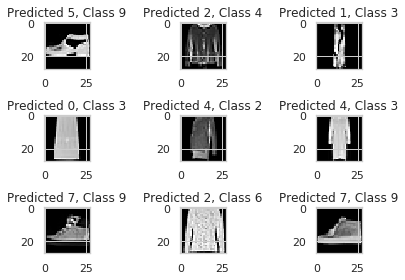

In [46]:
# Get the number of incorrect predictions and some plots showing the incorrectly predicted images.
incorrect = np.where(predicted_classes!=test_labels)[0]
print("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_data[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], test_labels[incorrect]))
    plt.tight_layout()

## Classification Report

Classification report will help us in identifying the misclassified classes in more detail. We will be able to observe for which class the model performed bad out of given 10 classes.

In [47]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(test_labels, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.85      0.89      0.87      1000
     Class 1       0.99      0.98      0.98      1000
     Class 2       0.86      0.90      0.88      1000
     Class 3       0.92      0.91      0.92      1000
     Class 4       0.86      0.89      0.88      1000
     Class 5       0.98      0.98      0.98      1000
     Class 6       0.80      0.72      0.76      1000
     Class 7       0.97      0.97      0.97      1000
     Class 8       0.99      0.98      0.98      1000
     Class 9       0.97      0.97      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



**Note :-** Above model has been trained using mostly the default parameters, there are alot of parameters to play with and also, parameters that can be tuned by using hyper-parameter tuning techniques.

# Adding Dropout Layer

Purpose of dropout layer is to overcome the problem of overfitting to some extent.

Dropout randomly turns off a fraction of neurons during the training process, reducing the dependency on the training set by some amount. How many fractions of neurons you want to turn off is decided by a hyperparameter, which can be tuned accordingly. This way, turning off some neurons will not allow the network to memorize the training data since not all the neurons will be active at the same time and the inactive neurons will not be able to learn anything.

## Encoder Part

In [48]:
def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    drop1 = Dropout(0.25)(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(drop1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    drop2 = Dropout(0.25)(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(drop2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    drop3 = Dropout(0.4)(conv3)
#     conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(drop3) #7 x 7 x 256 (small and thick)
#     conv4 = BatchNormalization()(conv4)
#     conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
#     conv4 = BatchNormalization()(conv4)
#     drop4 = Dropout(0.3)(conv4)
    return drop3

## Fully Connected Layer

In [49]:
def fc(enco):
    flat = Flatten()(enco)
    den = Dense(128, activation='relu')(flat)
    out = Dense(num_classes, activation='softmax')(den)
    return out

In [50]:
# Adding Early stopping for better learning of the network.

# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [51]:
encode = encoder(input_img)
full_model = Model(input_img,fc(encode))

In [52]:
# Setting first 19 layers trainable false.
for layer in full_model.layers[0:19]:
    layer.trainable = True

## Compiling The Model

In [53]:
# Compiling the model
full_model.compile(loss=keras.losses.categorical_crossentropy,
                   optimizer=keras.optimizers.Adam(),
                   metrics=['accuracy'])

In [54]:
# Printing model summary.
full_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_23 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_24 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0   

## Train The Model

In [55]:
classify_train = full_model.fit(train_X,
                                train_label,
                                batch_size=20,
                                epochs=20,
                                verbose=1,
                                validation_data=(valid_X, valid_label))

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 113s 2ms/step - loss: 0.4486 - accuracy: 0.8405 - val_loss: 0.3535 - val_accuracy: 0.8758
Epoch 2/20
48000/48000 [==============================] - 111s 2ms/step - loss: 0.3046 - accuracy: 0.8896 - val_loss: 0.2899 - val_accuracy: 0.8969
Epoch 3/20
48000/48000 [==============================] - 112s 2ms/step - loss: 0.2651 - accuracy: 0.9036 - val_loss: 0.3246 - val_accuracy: 0.8898
Epoch 4/20
48000/48000 [==============================] - 111s 2ms/step - loss: 0.2413 - accuracy: 0.9114 - val_loss: 0.2439 - val_accuracy: 0.9149
Epoch 5/20
48000/48000 [==============================] - 114s 2ms/step - loss: 0.2167 - accuracy: 0.9206 - val_loss: 0.2174 - val_accuracy: 0.9250
Epoch 6/20
48000/48000 [==============================] - 114s 2ms/step - loss: 0.2023 - accuracy: 0.9255 - val_loss: 0.2184 - val_accuracy: 0.9235
Epoch 7/20
48000/48000 [==============================] - 113s

## Plotting The Training And Validation Results

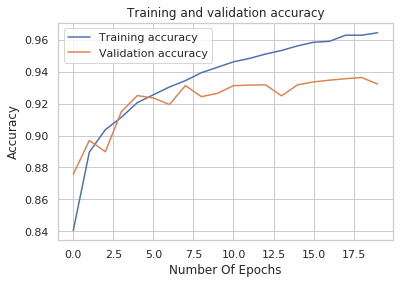

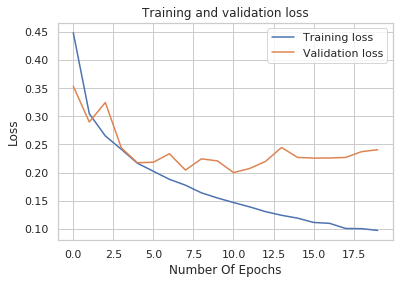

In [56]:
accuracy = classify_train.history['accuracy']
val_accuracy = classify_train.history['val_accuracy']
loss = classify_train.history['loss']
val_loss = classify_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number Of Epochs')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.xlabel('Number Of Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

**Conclusion :-** We are able to reduce the gap between Training and Validation curves for both Accuracy and Loss.